In [2]:
#!pip install seaborn
!pip install geopandas

  Using cached geopandas-0.9.0-py2.py3-none-any.whl (994 kB)
     |████████████████████████████████| 15.4 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 10.9 MB/s eta 0:00:01
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)


In [3]:
import pandas as pd
import os
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

In [4]:
ibtracs_directory = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/"

In [4]:
#os.system("wget %s" %(ibtracs_directory+"ibtracs.NA.list.v04r00.csv"))

In [5]:
df_NA = pd.read_csv("ibtracs.NA.list.v04r00.csv",low_memory=False)

In [6]:
df_NA.shape

(122825, 163)

In [7]:
df_NA.columns

Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'BOM_GUST_PER', 'REUNION_GUST', 'REUNION_GUST_PER', 'USA_SEAHGT',
       'USA_SEARAD_NE', 'USA_SEARAD_SE', 'USA_SEARAD_SW', 'USA_SEARAD_NW',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object', length=163)

In [8]:
df_NA['USA_STATUS']

0           
1           
2           
3           
4           
          ..
122820    TS
122821    TS
122822    TS
122823    TS
122824    TS
Name: USA_STATUS, Length: 122825, dtype: object

In [9]:
years = df_NA['SEASON'].values[1:]
years = [int(y) for y in years]
df_NA['Years'] = [0]+years

In [10]:
df_NA = df_NA[(df_NA['Years']>=1950) & 
              (df_NA['USA_STATUS'].apply(lambda x: any(x==y for y in ['TD','TS','DB','TC','HU','HR'])))]

In [11]:
storm_dates = pd.DataFrame()
storm_dates['MIN_DATE'] = df_NA.groupby('SID')['ISO_TIME'].apply(min)

In [12]:
storm_dates['MAX_DATE'] = df_NA.groupby('SID')['ISO_TIME'].apply(max)

In [13]:
storm_dates.reset_index(inplace=True)

In [14]:
storm_dates['DATES'] = ''
storm_dates['STATUS'] = ''
storm_dates['LATS'] = ''
storm_dates['LONS'] = ''
storm_dates['MIN_STATUS'] = ''
storm_dates['MAX_STATUS'] = ''
for i in range(storm_dates.shape[0]):
    min_date = storm_dates.iloc[i]['MIN_DATE']
    max_date = storm_dates.iloc[i]['MAX_DATE']
    sid = storm_dates.iloc[i]['SID']
    min_status = df_NA[(df_NA['SID']==sid) &
                       (df_NA['ISO_TIME']==min_date)]['USA_STATUS'].values
    max_status = df_NA[(df_NA['SID']==sid) &
                       (df_NA['ISO_TIME']==max_date)]['USA_STATUS'].values
    dates = df_NA[(df_NA['SID']==sid)]['ISO_TIME'].values
    status = df_NA[(df_NA['SID']==sid)]['USA_STATUS'].values
    lats = df_NA[(df_NA['SID']==sid)]['LAT'].values
    lons = df_NA[(df_NA['SID']==sid)]['LON'].values
    storm_dates.at[i,'DATES']=dates
    storm_dates.at[i,'STATUS']=status
    storm_dates.at[i,'LATS']=lats.astype(float)
    storm_dates.at[i,'LONS']=lons.astype(float)
    storm_dates.at[i,'MIN_STATUS']=status[0]
    storm_dates.at[i,'MAX_STATUS']=status[-1]

In [15]:
storm_dates.head()

,SID,MIN_DATE,MAX_DATE,DATES,STATUS,LATS,LONS,MIN_STATUS,MAX_STATUS
0,1950224N17305,1950-08-12 00:00:00,1950-08-21 21:00:00,"[1950-08-12 00:00:00, 1950-08-12 03:00:00, 195...","[TS, TS, TS, TS, TS, TS, TS, TS, TS, TS, TS, T...","[17.1, 17.4176, 17.7, 17.935, 18.2, 18.5622, 1...","[-55.5, -55.8722, -56.3, -56.8204, -57.4, -57....",TS,TS
1,1950231N12306,1950-08-18 12:00:00,1950-09-01 18:00:00,"[1950-08-18 12:00:00, 1950-08-18 15:00:00, 195...","[TD, TD, TD, TD, TD, TD, TD, TD, TS, TS, TS, T...","[12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, ...","[-54.0, -54.1025, -54.2, -54.2925, -54.4, -54....",TD,TD
2,1950234N11334,1950-08-21 12:00:00,1950-09-04 15:00:00,"[1950-08-21 12:00:00, 1950-08-21 15:00:00, 195...","[TS, TS, TS, TS, TS, TS, TS, TS, TS, TS, TS, T...","[11.1, 11.0502, 11.0, 10.95, 10.9, 10.8498, 10...","[-26.4, -26.9875, -27.6, -28.25, -28.9, -29.5,...",TS,TS
3,1950243N15304,1950-08-30 18:00:00,1950-09-11 21:00:00,"[1950-08-30 18:00:00, 1950-08-30 21:00:00, 195...","[HU, HU, HU, HU, HU, HU, HU, HU, HU, HU, HU, H...","[15.2, 15.3379, 15.5, 15.6998, 15.9, 16.0574, ...","[-55.6, -56.2574, -56.9, -57.515, -58.1, -58.6...",HU,HU
4,1950244N20277,1950-09-01 06:00:00,1950-09-09 18:00:00,"[1950-09-01 06:00:00, 1950-09-01 09:00:00, 195...","[TS, TS, TS, TS, TS, TS, TS, TS, TS, TS, TS, T...","[19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20.3, 20....","[-83.2, -83.2, -83.2, -83.2, -83.2, -83.1925, ...",TS,TD


NameError: name 'plot' is not defined

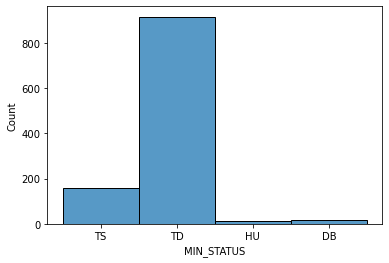

In [16]:
sns.histplot(x='MIN_STATUS',data=storm_dates)
plot.show()

In [ ]:
sns.histplot(x='MAX_STATUS',data=storm_dates)
plt.show()

In [18]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [19]:
colors = {'TD':'blue', 'TS':'purple', 'HU':'red', 'DB':'pink'}
color_map = lambda x: colors[x]

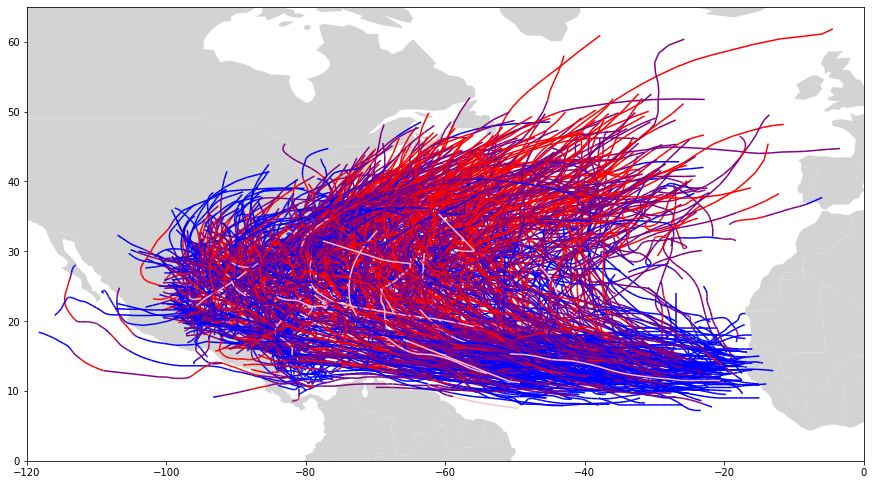

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
countries.plot(color="lightgrey",ax=ax)
for i in range(storm_dates.shape[0]):
    cmap = ListedColormap([color_map(x) for x in storm_dates.iloc[i]['STATUS']])
    x = storm_dates.iloc[i]['LONS']
    y = storm_dates.iloc[i]['LATS']
    xy = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])
    lc = LineCollection(segments, cmap = cmap)
    lc.set_array(y)
    ax.add_collection(lc)
    
plt.ylim(0,65)
plt.xlim(-120,0)
plt.show()